In [3]:
import random
from soh_lstm import set_seed
from pathlib import Path
import pandas as pd
import torch
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(42)



In [4]:
def load_data(data_dir: Path):
    """
    读取 data_dir 中所有的 .parquet 文件，按指定时间间隔（resample）重采样后合并。
    不再划分 train/val/test，直接返回一个合并后的 DataFrame。
    
    :param data_dir: 包含 .parquet 文件的目录
    :param resample: 重采样频率，如 "1min", "10min", "h" 等
    :return: 处理并重采样后的总 DataFrame
    """
    # 找到并排序所有 parquet 文件
    parquet_files = sorted(
        [f for f in data_dir.glob('*.parquet') if f.is_file()],
        key=lambda x: int(x.stem.split('_')[-1])  # 假设文件名里最后的数字可排序
    )
    print(f"共找到 {len(parquet_files)} 个文件，准备合并...")

    # 准备一个列表，用于存放处理后的 DataFrame
    data_frames = []

    for file_path in tqdm.tqdm(parquet_files):
        df = pd.read_parquet(file_path)

        # 只保留需要的列，减少内存使用
        columns_to_keep = ['Testtime[s]', 'SOC_ZHU', 'SOH_ZHU']
        df_processed = df[columns_to_keep].copy()
        df_processed.dropna(inplace=True)
        
        cell_id_str = file_path.stem.split('_')[-1]
        df_processed['cell_id'] = int(cell_id_str)

        # 将 Testtime[s] 转为整型秒，再生成对应 Datetime 列
        df_processed['Testtime[s]'] = df_processed['Testtime[s]'].round().astype(int)
        start_date = pd.Timestamp("2023-02-02")
        df_processed['Datetime'] = pd.date_range(
            start=start_date,
            periods=len(df_processed),
            freq='s'
        )

        # 按指定频率重采样，并 reset index
        df_sampled = df_processed.resample('min', on='Datetime').mean().reset_index(drop=False)

        data_frames.append(df_sampled)

    # 将所有文件的数据合并
    df_all = pd.concat(data_frames, ignore_index=True)

    print(f"合并后 DataFrame 形状: {df_all.shape}")
    return df_all

data_dir = Path("../01_Datenaufbereitung/Output/Calculated/")
all_data = load_data(data_dir)
print(all_data.head())



共找到 15 个文件，准备合并...


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:59<00:00,  4.00s/it]


合并后 DataFrame 形状: (2866875, 5)
             Datetime  Testtime[s]  SOC_ZHU   SOH_ZHU  cell_id
0 2023-02-02 00:00:00     474437.5      1.0  1.000000      1.0
1 2023-02-02 00:01:00     474497.5      1.0  0.999999      1.0
2 2023-02-02 00:02:00     474557.5      1.0  0.999998      1.0
3 2023-02-02 00:03:00     474617.5      1.0  0.999997      1.0
4 2023-02-02 00:04:00     474677.5      1.0  0.999996      1.0


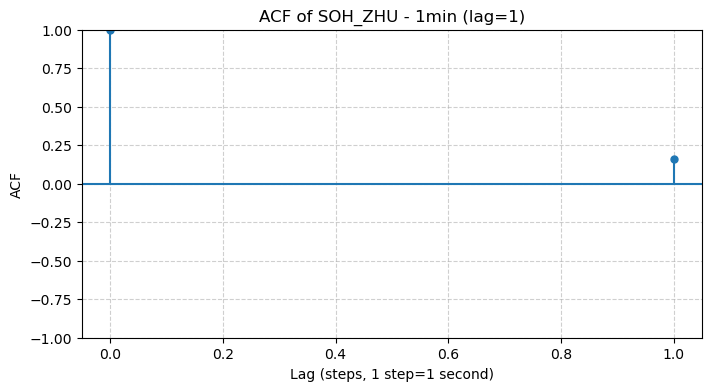

In [ ]:
def plot_acf_for_seconds_data(soh_series, time_label, lag_value):
    """
    在分级数据上，根据指定的 lag_value 绘制 ACF。
    :param soh_series: 每秒采样的 SOH 序列 (pd.Series)
    :param time_label: 用于图表标题说明的时间尺度，如 '1min', '10min','30min', '1h'
    :param lag_value: 滞后阶数，如 60, 600, 3600
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_acf(soh_series.dropna(), lags=lag_value, ax=ax)
    plt.title(f'ACF of SOH_ZHU - {time_label} (lag={lag_value})')
    plt.xlabel('Lag (steps, 1 step=1 second)')
    plt.ylabel('ACF')
    plt.grid(alpha=0.6, linestyle='--')
    plt.show()

# 假设 all_data 是秒级采样，并包含 'Datetime' 和 'SOH_ZHU' 列
# 先排序并将 Datetime 设为索引，确保时序正确
df_sorted = all_data.sort_values('Datetime').set_index('Datetime')
soh_seconds = df_sorted['SOH_ZHU'].dropna()

# 分别绘制 1 分钟、10 分钟、1 小时
plot_acf_for_seconds_data(soh_seconds, '1min', 1)
plot_acf_for_seconds_data(soh_seconds, '10min', 10)
plot_acf_for_seconds_data(soh_seconds, '30min', 30)
plot_acf_for_seconds_data(soh_seconds, '1h', 60)